**Import Libraries**

In [78]:
# Standard Libraries
import os
import zipfile
from glob import glob
import random

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2
import pydicom
from PIL import Image

**Define Parameters**

In [79]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Disease labels
disease_labels = [
    "Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity",
    "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
    "Pneumothorax", "Pulmonary fibrosis"
]

# **Step 1: Load Data**

In [80]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract VinDr-CXR dataset
extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [81]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].str.contains('No finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(extracted_path, 'train', f"{x}.dicom"))

    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [82]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Aortic enlargement,Atelectasis,...,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,Path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,0,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/vinbigdat...


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Images**

In [83]:
unique_patients = df['image_id'].nunique()
print(f"Number of images: {unique_patients}")

Number of images: 15000


**Distribution of Disease Label**

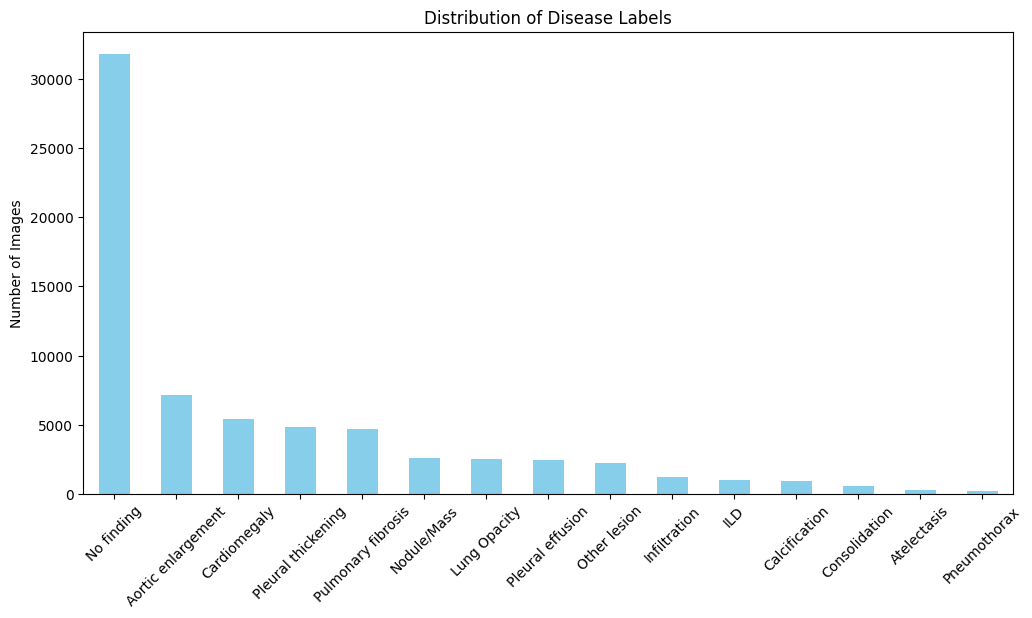

In [84]:
# Retrive labels from dataframe
labels_df = df[disease_labels + ['No finding']]

# Count each label
counted_labels_df = labels_df.sum()

# Sort labels
counted_labels_df = counted_labels_df.sort_values(ascending=False)

# Plott counted_labels
plt.figure(figsize=(12, 6))
counted_labels_df.plot(kind='bar', color='skyblue')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.title('Distribution of Disease Labels')
plt.show()

**Diseases per Image Distribution**

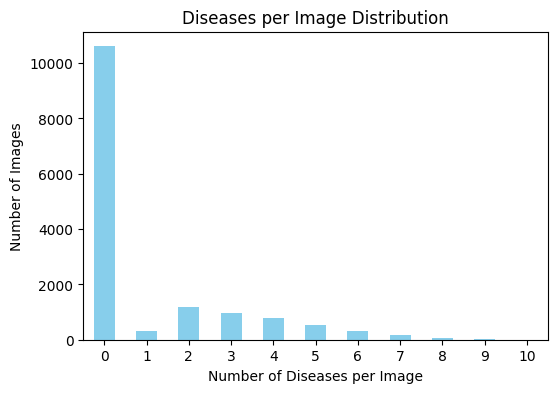

In [85]:
# Ensure each disease is represented max one time per image
df_grouped = df.groupby('image_id')[disease_labels].max()

# Calculate the total number of diseases per image
df_grouped['Number of Diseases'] = df_grouped.sum(axis=1)

# Compute the distribution of disease counts across all images
disease_count_distribution = df_grouped['Number of Diseases'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(6, 4))
disease_count_distribution.plot(kind='bar', color='skyblue')
plt.title("Diseases per Image Distribution")
plt.xlabel("Number of Diseases per Image")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

**Distribution of Co-occurrence of Labels**

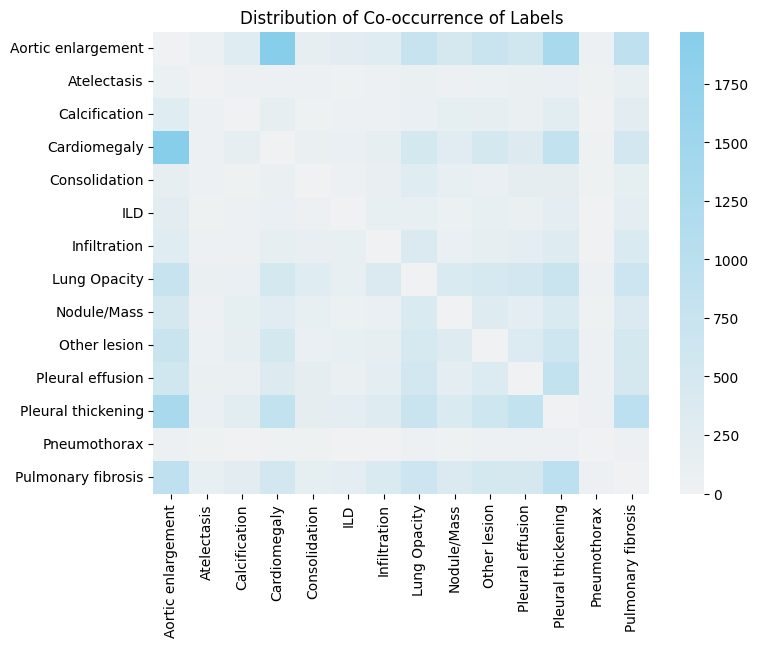

In [86]:
# Ensure each disease is represented max one time per image
df_grouped = df.groupby('image_id')[disease_labels].max()

# Calculate co-occurrence
co_occurrence_df = df_grouped[disease_labels].T.dot(df_grouped[disease_labels])

# Remove the diagonal
for disease in disease_labels:
    co_occurrence_df.loc[disease, disease] = 0

# Create a skyblue colormap
custom_cmap = sns.light_palette("skyblue", as_cmap=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_df, cmap=custom_cmap)
plt.title("Distribution of Co-occurrence of Labels")
plt.show()

**Distribution of Disease Size**

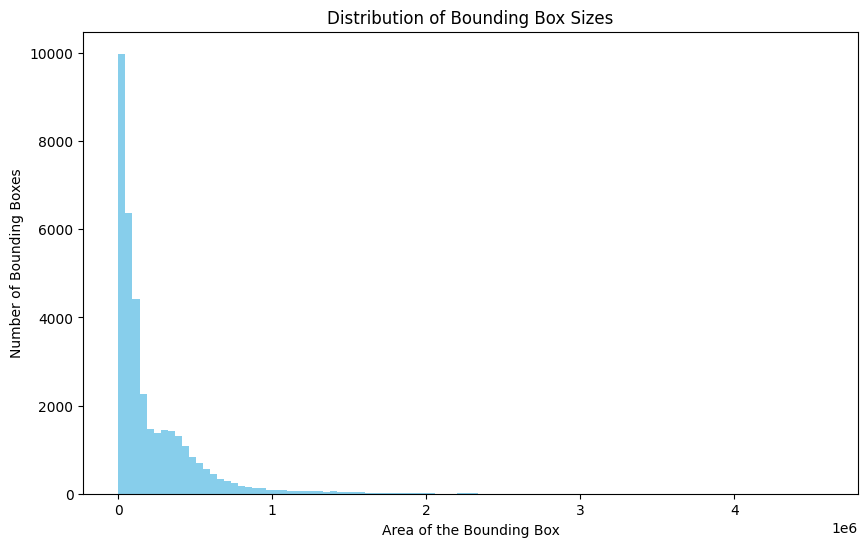

In [87]:
# Filter out NaN values
df_bbox = df.dropna(subset=['x_min', 'y_min', 'x_max', 'y_max']).copy()

# Compute width of the bounding box
df_bbox['width'] = df_bbox['x_max'] - df_bbox['x_min']

# Compute height of the bounding box
df_bbox['height'] = df_bbox['y_max'] - df_bbox['y_min']

# Compute area of the bounding box
df_bbox['area'] = df_bbox['width'] * df_bbox['height']

# Plot the distribution of bounding box sizes
plt.figure(figsize=(10,6))
plt.hist(df_bbox['area'], bins=100, color='skyblue')
plt.xlabel('Area of the Bounding Box')
plt.ylabel('Number of Bounding Boxes')
plt.title('Distribution of Bounding Box Sizes')
plt.show()

**Image Quality**

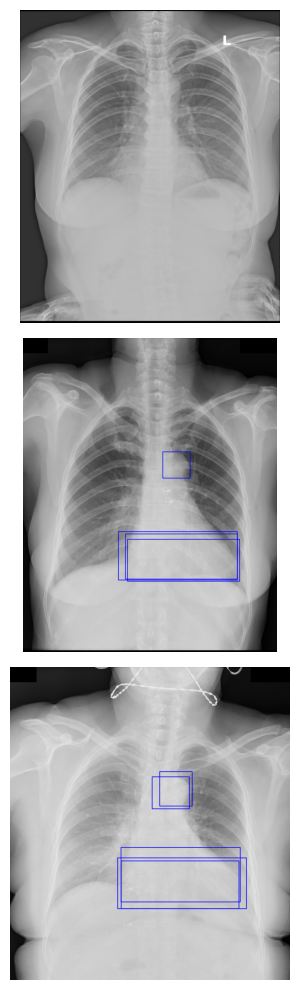

In [88]:
# Randomly select 3 images
sample_images = random.sample(list(df['Path']), 3)

# Define box parameters
thickness = 5
box_color = (0, 0, 255)

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images):

    # Read the DICOM file
    ds = pydicom.dcmread(img_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Normalize the image to range [0, 1]
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    
    # Convert to three channels
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Retrieve all rows for the selected image
    rows = df[df['Path'] == img_path]

    # Loop over each bounding box for the image
    for _, row in rows.iterrows():
        if not np.isnan(row['x_min']):
            x_min = int(row['x_min'])
            y_min = int(row['y_min'])
            x_max = int(row['x_max'])
            y_max = int(row['y_max'])
            
            # Draw the bounding rectangle
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), box_color, thickness)
    
    plt.subplot(3, 1, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()